In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import yaml
import argparse
import numpy as np
from models import *
from PIL import Image
from numpy import asarray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Dataset

In [23]:

# model_checkpoint= '/home/yitongt/prot2face/logs/VanillaVAE/version_3/checkpoints/last.ckpt'
# model = VanillaVAE(in_channels=3, latent_dim=128)

model_checkpoint= '/home/yitongt/prot2face/logs/ConditionalVAE/version_0/checkpoints/last.ckpt'
model = ConditionalVAE(in_channels=3, latent_dim=128, num_classes=40)


checkpoint = torch.load(model_checkpoint)
state_dict = {k.replace('model.', ''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
# model.load_state_dict(checkpoint['state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # epoch = checkpoint['epoch']
# # loss = checkpoint['loss']

model.eval()


ConditionalVAE(
  (embed_class): Linear(in_features=40, out_features=4096, bias=True)
  (embed_data): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Ba

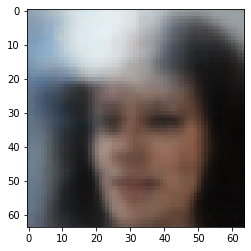

In [119]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

index = 35
label = np.full((1, 40), 0)
label[:,index] = 1


sample = model.sample(num_samples =1, labels=torch.Tensor(label), current_device='cpu')


sample = sample.detach().numpy()[0]
sample = sample.transpose((1,2,0))
imgplot = plt.imshow(sample, interpolation='nearest')
plt.show()


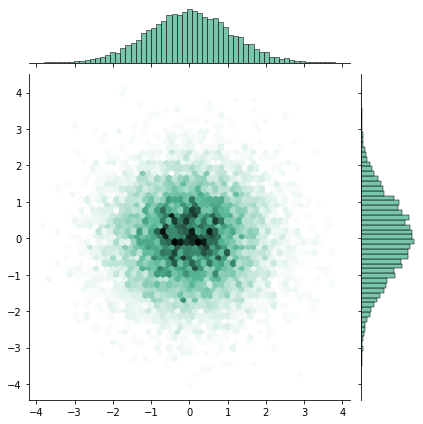

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns

# This already draws random numbers from a GAUSSIAN distribution.
# So we're set...
z = torch.randn(10000, 128).detach().numpy()
pca = PCA(n_components=2)
pcaed_z = pca.fit_transform(z)
sns.jointplot(x=pcaed_z[:, 0], y=pcaed_z[:, 1], kind="hex", color="#4CB391")


# Let's try using my image

In [15]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

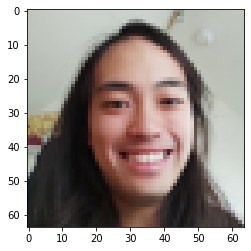

In [16]:
def load_image(img_name):
    img = Image.open(img_name)
 
    width, height = img.size
    min_size = min(width, height)

    # Make the image square & downsample to 64 x 64
    new_size = (min_size, min_size)
    img = img.resize(new_size)
    img = img.resize((64, 64))
    return img

yitong_imgs = [load_image('yitong_faces/big_smile.jpg'),
    load_image('yitong_faces/bigeyes_pucker.jpg'),
    load_image('yitong_faces/bigeyes_surprised.jpg'),
    load_image('yitong_faces/frowning.jpg'),
    load_image('yitong_faces/medium_smile.jpg'),
    load_image('yitong_faces/neutral_smile.jpg'),
    load_image('yitong_faces/tongue.jpg'),
    load_image('yitong_faces/winking.jpg'),
    load_image('yitong_faces/neutral_smile.jpg'),
    ]
# np.stack(
#     [load_image('yitong_faces/big_smile.jpg'),
#     load_image('yitong_faces/bigeyes_pucker.jpg'),
#     load_image('yitong_faces/bigeyes_surprised.jpg'),
#     load_image('yitong_faces/frowning.jpg'),
#     load_image('yitong_faces/medium_smile.jpg'),
#     load_image('yitong_faces/neutral_smile.jpg'),
#     load_image('yitong_faces/tongue.jpg'),
#     load_image('yitong_faces/winking.jpg'),
#     load_image('yitong_faces/neutral_smile.jpg'),
#     ],
#     axis=0
# )
# asarray(
imgplot = plt.imshow(yitong_imgs[0], interpolation='nearest')
plt.show()


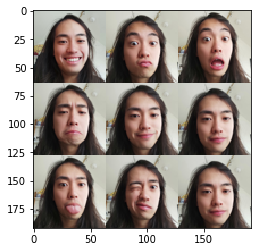

In [17]:
grid = image_grid(yitong_imgs, rows=3, cols=3)
imgplot = plt.imshow(grid, interpolation='nearest')

plt.show()


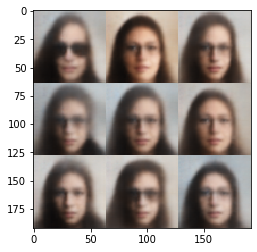

In [115]:
# Rescale the image tensor to values between 0 and 1 from values 0 to 256
yitong_imgs_tensor = torch.Tensor(np.stack(
    [asarray(img) for img in yitong_imgs],
    axis=0
).transpose(0,3,1,2)) / 256


index = 15
label = np.zeros((len(yitong_imgs_tensor), 40))
label[:,index] = 1
recons = model.generate(yitong_imgs_tensor, labels=torch.Tensor(label), current_device='cpu')

rows, cols = 3,3
imgs_as_arrays = recons.detach().numpy().transpose(0,2,3,1)



# assert len(imgs_as_arrays) == rows*cols
imgs_as_arrays = (imgs_as_arrays * 255).astype(np.uint8)
imgs = [Image.fromarray(img_array) for img_array in imgs_as_arrays]


w, h = imgs[0].size
grid = Image.new('RGB', size=(cols*w, rows*h))
grid_w, grid_h = grid.size

for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
imgplot = plt.imshow(grid, interpolation='nearest')

plt.show()


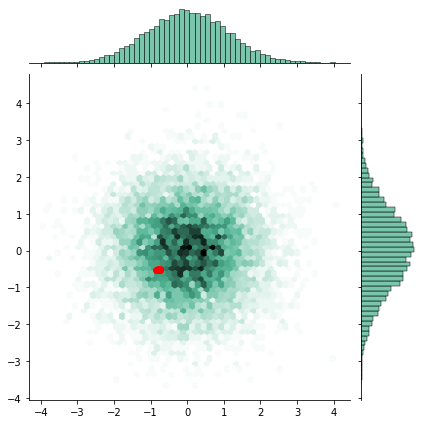

In [20]:
# from sklearn.decomposition import PCA
# import seaborn as sns

# # This already draws random numbers from a GAUSSIAN distribution.
# # So we're set...
# z_distribution = torch.randn(10000, 128).detach().numpy()
# pca = PCA(n_components=2)
# pca.fit(z_distribution)
# pcaed_z_distrib = pca.transform(z_distribution)
# sns.jointplot(x=pcaed_z_distrib[:, 0], y=pcaed_z_distrib[:, 1], kind="hex", color="#4CB391")

# pcaed_z = pca.transform(log_var.detach().numpy())
# plt.scatter(x=pcaed_z[:, 0], y=pcaed_z[:, 1], color='red')

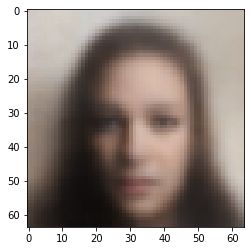

In [57]:
imgplot = plt.imshow(recons[3].detach().numpy().transpose(1,2,0), interpolation='nearest')

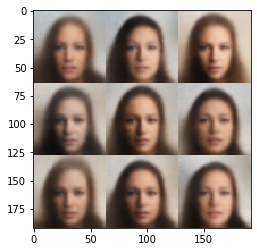

In [58]:
rows, cols = 3,3
imgs_as_arrays = recons.detach().numpy().transpose(0,2,3,1)


# assert len(imgs_as_arrays) == rows*cols
imgs_as_arrays = (imgs_as_arrays * 255).astype(np.uint8)
imgs = [Image.fromarray(img_array) for img_array in imgs_as_arrays]


w, h = imgs[0].size
grid = Image.new('RGB', size=(cols*w, rows*h))
grid_w, grid_h = grid.size

for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
imgplot = plt.imshow(grid, interpolation='nearest')

plt.show()
